# CS 6331 - Multimedia Systems: Android Picture Blur Classifier Model
### Autor: Alejandro Urquieta

# Model Training

In [3]:
# Imports

import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [4]:
# Verify CUDA
import torch

print(torch.cuda.is_available())

True


In [5]:
# Paths to dataset
datasetDir = 'trainData/blurDataset'
categories = ['defocused_blurred', 'motion_blurred', 'sharp']

# Function to load images based on the folder
def loadImages(category, imgSize=(224, 224)):
    data = []
    categoryPath = os.path.join(datasetDir, category)
    for imgName in os.listdir(categoryPath):
        imgPath = os.path.join(categoryPath, imgName)
        image = cv2.imread(imgPath)
        image = cv2.resize(image, imgSize)
        image = img_to_array(image)
        data.append(image)
    return np.array(data)

defocusedBlurredImages = loadImages('defocused_blurred')
motionBlurredImages = loadImages('motion_blurred')
sharpImages = loadImages('sharp')

# Label creation
labels = np.concatenate([
    np.zeros(len(defocusedBlurredImages)),  # Label: 0 for defocused_blurred
    np.ones(len(motionBlurredImages)),      # Label: 1 for motion_blurred
    np.full(len(sharpImages), 2)            # Label: 2 for sharp
])

# Combine and normalize the dataset
images = np.concatenate([defocusedBlurredImages, motionBlurredImages, sharpImages])
images = images / 255.0  # Normalize to [0, 1]

In [6]:
# Setting up the x and y test and train values using an 80:20 ratio
xTrain, xTest, yTrain, yTest = train_test_split(images, labels, test_size=0.2, random_state=42)
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42)

In [7]:
# Load MobileNetV2 without the top layers
baseModel = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers for classification
x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # 3 classes: defocused, motion blurred, sharp

model = Model(inputs=baseModel.input, outputs=predictions)

# Freeze base model layers
for layer in baseModel.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [8]:
# Train Model
history = model.fit(xTrain, yTrain, validation_data=(xVal, yVal), epochs=10, batch_size=32)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 498ms/step - accuracy: 0.5920 - loss: 0.9458 - val_accuracy: 0.7560 - val_loss: 0.6348
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 438ms/step - accuracy: 0.8888 - loss: 0.3330 - val_accuracy: 0.7560 - val_loss: 0.5997
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 450ms/step - accuracy: 0.9367 - loss: 0.2021 - val_accuracy: 0.8095 - val_loss: 0.5841
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 451ms/step - accuracy: 0.9879 - loss: 0.0992 - val_accuracy: 0.8214 - val_loss: 0.5780
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 488ms/step - accuracy: 0.9963 - loss: 0.0617 - val_accuracy: 0.8214 - val_loss: 0.5779
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 463ms/step - accuracy: 1.0000 - loss: 0.0469 - val_accuracy: 0.8274 - val_loss: 0.5873
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 452ms/step - accuracy: 1.0000 - loss: 0.0307 - val_accuracy: 0.8274 - val_loss: 0.6106
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 458ms/step - accuracy: 0.9998 - loss: 0.0232 - val_accuracy

In [9]:
# Test model
loss, accuracy = model.evaluate(xTest, yTest)
print(f'Test accuracy: {accuracy:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.8376 - loss: 0.5471
Test accuracy: 0.8190


In [10]:
# Create a concrete function from the model
runModel = tf.function(lambda x: model(x))
concreteFunc = runModel.get_concrete_function(tf.TensorSpec([None, 224, 224, 3], model.inputs[0].dtype))

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_concrete_functions([concreteFunc])
tfliteModel = converter.convert()

# Save the converted model
with open('blur_model.tflite', 'wb') as f:
    f.write(tfliteModel)

# Training and Evaluation Results

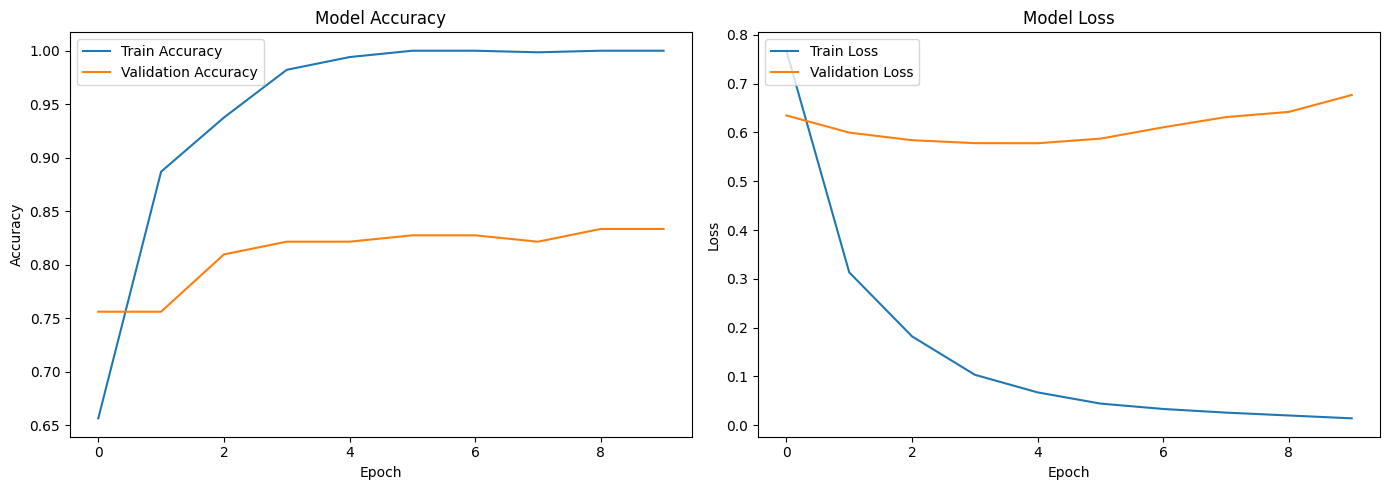

In [12]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy and loss values from existing 'history'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


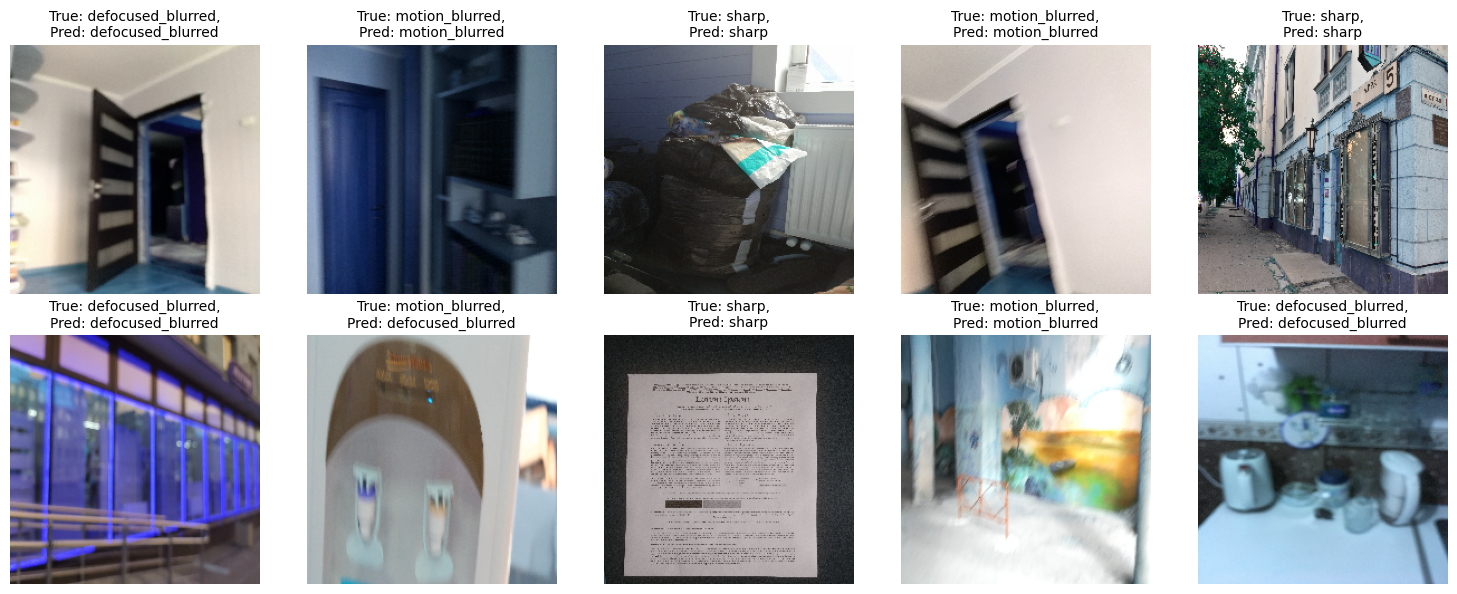

In [17]:
# Plotting sample predictions from the test set
sample_indices = np.random.choice(len(xTest), 10, replace=False)
sample_images = xTest[sample_indices]
sample_labels = yTest[sample_indices]

predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

# Display sample images with their predicted and true labels
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i])
    ax.set_title(f"True: {categories[int(sample_labels[i])]},\nPred: {categories[predicted_labels[i]]}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()


# Testing the Model

In [11]:
import tensorflow as tf

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="blur_model.tflite")
interpreter.allocate_tensors()

# Get input and output details
inputDetails = interpreter.get_input_details()
outputDetails = interpreter.get_output_details()

# Load and preprocess your image
def preprocessImage(imagePath):
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (224, 224))
    image = image.astype(np.float32)
    image = image / 255.0  # Normalize
    return np.expand_dims(image, axis=0)  # Add batch dimension

imagePath = 'testData/blurTest/clear1.jpg'
inputData = preprocessImage(imagePath)

# Set the input tensor
interpreter.set_tensor(inputDetails[0]['index'], inputData)

# Run inference
interpreter.invoke()

# Get the output
outputData = interpreter.get_tensor(outputDetails[0]['index'])
predictedClass = np.argmax(outputData)
classNames = ['defocused_blurred', 'motion_blurred', 'sharp']

# Output the predicted class
print(f"Predicted class: {classNames[predictedClass]}")

Predicted class: sharp
